# 사전 설정


🎯 미션 목표

- 흉부 X-Ray 이미지를 입력으로 폐렴 여부를 분류하는 Classification 모델 개발

- 이미지 전처리, 증강 기법, Transfer Learning, Fine-Tuning 기법을 적용

- 모델 성능 비교 및 평가

📂 데이터 구성

- train: 훈련 데이터

- val: 검증 데이터

- test: 테스트 데이터

📌 필수 포함 내용

- 데이터 처리 과정: 로드, 전처리, 증강

- 모델 학습 과정: Transfer Learning + Fine-Tuning (Frozen / Partial / Full)

- 성능 평가: Accuracy, Precision, Recall, F1-score

- 비교 실험: 모델별 성능 비교 및 결과 분석

- 마크다운 설명: 각 단계 의도 및 실행 결과 설명

In [ ]:
!pip install torchinfo

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# @title 디바이스 설정

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('drive')
path = '/content/drive/MyDrive/study/data'

Mounted at drive


# 데이터 분석


- 다양한 이미지 전처리 및 증강 기법을 적용하고, Transfer Learning 및 Fine-Tuning 기법을 활용하여 모델 성능을 평가
-  Chest X-Ray Images (Pneumonia) 데이터셋을 사용하며, 데이터는 훈련(train), 검증(val), 테스트(test)로 구성되어 있다.

In [ ]:
# @title Data Download

import kagglehub
import os                                                                       # 경로 조작용 (join, exists 등)
import shutil                                                                   # 디렉토리/파일 복사, 삭제 유틸

# Download latest version
kaggle_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", kaggle_path)

# 기존 chest_xray 폴더가 있으면 삭제(덮어쓰기 방지)
if os.path.exists(os.path.join(path, 'chest_xray')):
    shutil.rmtree(os.path.join(path, 'chest_xray'))
# Kaggle 데이터셋에서 chest_xray 폴더 복사 → 내 작업 경로(path) 안에 복사본 생성
shutil.copytree(
    os.path.join(kaggle_path, 'chest_xray', 'chest_xray'),                      # 원본 경로
    os.path.join(path, 'chest_xray'),                                           # 새 경로
    dirs_exist_ok=True                                                          # 이미 있으면 병합 허용
)

# 새롭게 만든 chest_xray 경로 저장
new_path = os.path.join(path, 'chest_xray')

# train/val/test 세부 폴더 경로 정의
train_dir = os.path.join(new_path, "train")
val_dir = os.path.join(new_path, "val")
test_dir = os.path.join(new_path, "test")

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
# @title 데이터 수량 확인
dataset_path = os.path.join(new_path)                                           # 최상위 chest_xray 경로

# 각 split(train/val/test) 안에 NORMAL, PNEUMONIA 이미지 개수 출력
def count_images(diretory):
    categories = ["train", "test", "val"]
    for category in categories:
        normal_path = os.path.join(diretory, category, "NORMAL")                # 정상 이미지 폴더
        pneumonia_path = os.path.join(diretory, category, "PNEUMONIA")          # 폐렴 이미지 폴더

        num_normal = len(os.listdir(normal_path))                               # 정상 이미지 파일 개수
        num_pneumonia = len(os.listdir(pneumonia_path))                         # 폐렴 이미지 파일 개수

        print(f"{category} - 정상: {num_normal}개, 폐렴: {num_pneumonia}개")

# 데이터셋 분포 확인
count_images(dataset_path)

train - 정상: 1342개, 폐렴: 3876개
test - 정상: 234개, 폐렴: 390개
val - 정상: 9개, 폐렴: 9개


- 데이터 전처리 때 validation 자료 보강 필요

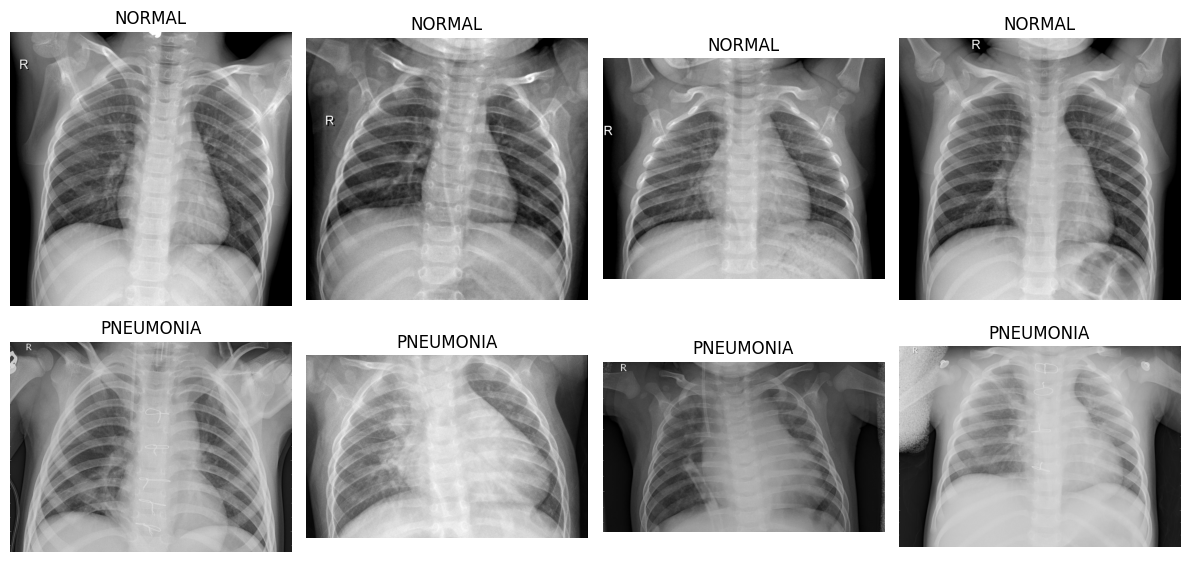

In [ ]:
# @title 데이터 샘플 확인
import cv2
import random

# 데이터셋에서 무작위 샘플 이미지를 보여주는 함수
def show_samples(category="train"):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    # 2행×4열 서브플롯 생성 (총 8개 이미지 표시), 화면 크기는 12×6 인치

    for i, label in enumerate(["NORMAL", "PNEUMONIA"]):                         # 두 개 클래스(NORMAL, PNEUMONIA)에 대해 반복
        img_dir = os.path.join(dataset_path, category, label)                   # 예: ./data/train/NORMAL, ./data/train/PNEUMONIA
        sample_files = random.sample(os.listdir(img_dir), 4)                    # 해당 폴더에서 무작위로 4개 파일 뽑기

        for j, file in enumerate(sample_files):                                 # 뽑은 파일들 순회
            img_path = os.path.join(img_dir, file)                              # 이미지 전체 경로 생성
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                    # OpenCV로 이미지 읽기 (흑백 모드)
            axes[i, j].imshow(img, cmap='gray')                                 # 서브플롯에 흑백 컬러맵으로 출력
            axes[i, j].set_title(f'{label}')                                    # 해당 클래스명 타이틀
            axes[i, j].axis('off')                                              # 축 눈금 제거 (깔끔하게 표시)


    plt.tight_layout()                                                          # 서브플롯 간격 자동 조정
    plt.show()                                                                  # 그림 화면에 표시

# train 폴더에서 샘플 8장 확인
show_samples('train')

# 데이터 전처리

In [ ]:
# @title validation 자료 보강

# 데이터셋 디렉토리 지정
train_dir = os.path.join(dataset_path, "train")                                 # 학습 데이터 폴더 경로
val_dir = os.path.join(dataset_path, "val")                                     # 검증 데이터 폴더 경로
test_dir = os.path.join(dataset_path, "test")                                   # 테스트 데이터 폴더 경로

# test 자료 중 일부를 val로 옮기는 함수
def move_test(label, rate=0.2, verbose=False):
    test_path = os.path.join(test_dir, label)                                   # 예: ./data/test/NORMAL
    val_path = os.path.join(val_dir, label)                                     # 예: ./data/val/NORMAL

    files = os.listdir(test_path)                                               # test 폴더 안에 있는 모든 파일 리스트
    num_move = int(len(files) * rate)                                           # 옮길 개수 = 전체 * 비율(rate)

    val_files = random.sample(files, num_move)                                  # 무작위로 num_move개 뽑음
    for file in val_files:                                                      # 반복문 돌면서
        shutil.move(                                                            # test → val 폴더로 파일 이동
            os.path.join(test_path, file),
            os.path.join(val_path, file)
        )
        if verbose:                                                             # verbose=True면 경로 출력
            print(f"{os.path.join(test_path, file)} moved to {os.path.join(val_path, file)}")
    print(f"{label} - {num_move}개 이동")                                         # 최종 몇 개 옮겼는지 출력

# 실행: NORMAL, PNEUMONIA 데이터 각각 옮기기
move_test("NORMAL")
move_test("PNEUMONIA")

# 결과 확인 (사용자 정의 함수라고 가정)
print("=======결과 확인======")
count_images(dataset_path)  # 각 폴더별 이미지 개수 세기

NORMAL - 46개 이동
PNEUMONIA - 78개 이동
=======결과 확인======
train - 정상: 1342개, 폐렴: 3876개
test - 정상: 188개, 폐렴: 312개
val - 정상: 55개, 폐렴: 87개


In [ ]:
# @title 데이터 전처리
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2

data_transforms = {
    "train": v2.Compose([
        v2.Resize((260, 260)),                          # 이미지 크기 조정
        v2.RandomRotation(20),                          # random회전 (-20 ~ 20)
        v2.RandomHorizontalFlip(),                      # 50%확률로 좌우반전
        v2.RandomCrop((224, 224)),                      # 랜던한 위치를 224 x 224로 자르기
        v2.ToImage(),                                   # PIL/ndarray → Torch Tensor(HWC→CHW)로 변환
        v2.ToDtype(dtype=torch.float32, scale=True),    # 텐서 dtype을 float32로 바꾸고 0~255픽셀을 0~1 실수범위로 스케일링
        v2.Normalize([0.5],[0.5])                       # 참고 자료 https://muddy-acapella-be1.notion.site/Normalize-27d428f958b180828fe3daeef3370ff3?source=copy_link
    ]),
    "val": v2.Compose([
        v2.Resize((224, 224)),                          # 검증은 고정 크기만 맞춰 일관성 유지!
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize([0.5],[0.5])
    ]),
    "test": v2.Compose([
        v2.Resize((224, 224)),                          # 테스트도 검증과 동일하게(재현성 중요)
        v2.ToImage(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Normalize([0.5],[0.5])
    ])
}

In [ ]:
# @title 데이터 셋

# 데이터 셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

# 클래스 확인
class_names = train_dataset.classes

In [ ]:
# @title 데이터 샘플러를 위한 가중치 생성 함수

def make_weights(labels, nclasses):
    labels = np.array(labels)                               # labels 리스트를 넘파이 배열로 변환
    weight_list = []                                        # 각 샘플의 가충치를 저장할 리스트 초기화

    for cls in range(nclasses):                             # 클래스 개수만큼 반복
        idx = np.where(labels == cls)[0]                    # labels 중 현재 cls에 해당하는 인덱스 찾기
        count = len(idx)                                    # 현재 클래스 데이터 개수 카운트
        weight = 1 / count                                  # 클래스별 가중치 = 데이터 개수의 역수
        weights = [weight] * count                          # 그 클래스의 모든 샘픔에 동일 가중치 부여
        weight_list += weights                              # 리스트에 추가

    return weight_list                                      # 전체 샘픙에 대한 가중치 리스트 반환

In [ ]:
# train_dataset 안에 있는 라벨 정보를 바탕으로 가중치 생성
weights = make_weights(train_dataset.targets, len(train_dataset.classes))       # 클래스 개수 (예: NORMAL, PNEUMONIA → 2)
# 리스트 형태의 weights → PyTorch Tensor로 변환
weights = torch.tensor(weights)
print(weights)

tensor([0.0007, 0.0007, 0.0007,  ..., 0.0003, 0.0003, 0.0003])


In [ ]:
# @title sampler를 이용한 DataLoader

sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))             # weights = make_weights에서 만든 tensor

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, sampler=sampler)     # 배치크기 64, shuffle 미사용(sampler가 이미 랜덤 추출), weightedRandomSampler로 균형있게 샘플 추출
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)                          # 배치크기 4(작은 배치로 메모리 절약), 검증은 순서고정
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)                        # 배치크기 32, 순서고정

# 데이터셋 크기 출력
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 5216
Validation samples: 140
Test samples: 500


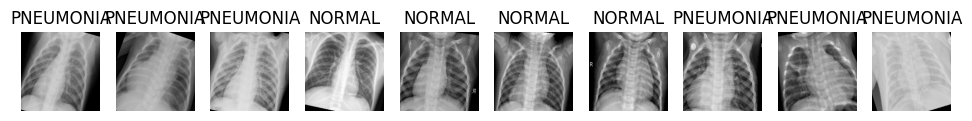

In [ ]:
# @title 전처리 확인

data_iter = iter(train_loader)                              # 데이터로더를 이터레이터로 변환
images, labels = next(data_iter)                            # 첫 번째 배치 꺼내오기

num_samples = 10

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i in range(num_samples):
    img = images[i].numpy().squeeze()                       # Tensor → NumPy 배열, (C,H,W) 유지, 불필요한 차원 제거
    img = (img * 0.5) + 0.5                                 # Normalize 복원
    axes[i].imshow(img.transpose(1,2,0), cmap='gray')       # (C,H,W) → (H,W,C)로 변환 후 시각화
    axes[i].set_title(class_names[labels[i].item()])        # 라벨 번호를 class_names에서 문자열로 변화해 제목 표시
    axes[i].axis('off')                                     # 축 눈금 제거

plt.show()


# CNN 모델

In [ ]:
# @title 기본 모델 정의
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom CNN 모델 정의
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):                          # 클래스 개수 (이진분류)
        super(CustomCNN, self).__init__()                       # 부모클래스 초기화

        # 합성곱 블록_1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)       # RGB 3채널 → 32채널 특징맵
        self.bn1 = nn.BatchNorm2d(32)                                           # 배치 정규화 → 학습안정화
        # 합성곱 블로_2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)     # 32채널 → 64채널
        self.bn2 = nn.BatchNorm2d(64)
        # 합성공 블록_3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)     # 64채널 → 128채널
        self.bn3 = nn.BatchNorm2d(128)
        # 합성곱 블록_4
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)    # 128채널 유지
        self.bn4 = nn.BatchNorm2d(128)

        # 공간축소 → MaxPooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 전역 평균 풀링 → (H, W) 크기 상관없이(1,1)로 압축
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))

        # 완전열결 계층
        self.fc1 = nn.Linear(128, 64)                           # 128차원 특징 → 64차원 은닉층
        self.dropout = nn.Dropout(0.5)                          # 과적합 방지 (50%뉴런 무작위 제거)
        self.fc2 = nn.Linear(64, num_classes)                   # 64차원 은닉층 → 최종 2개 클래스 점수

    # forward(순전파) 정의
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))          # conv1 → bn1 → ReLU → MaxPool
        x = (F.relu(self.bn2(self.conv2(x))))                   # conv2 → bn2 → ReLU
        x = self.pool(F.relu(self.bn3(self.conv3(x))))          # conv3 → bn3 → ReLU → MaxPool
        x = F.relu(self.bn4(self.conv4(x)))                     # conv4 → bn4 → ReLU

        x = self.global_avg_pool(x)                             # 전역 평균 풀링 (특징 맴 크기 1x1)
        x = torch.flatten(x, 1)                                 # 배치 제외 나머지 평탄화

        x = F.relu(self.fc1(x))                                 # 완전연결 1 → ReLU
        x = self.dropout(x)                                     # Dropout. (50%)
        x = self.fc2(x)                                         # 완전연결 2 → 클래스 점수 출력
        return x

In [ ]:
# @title 학습준비 Loss, Optim, Model
import torch.optim as optim

# 클래수 수  설정
num_classes = len(class_names)                                  # 분류할 클래스 개수 계산

model_basic = CustomCNN(num_classes).to(device)                 # 모델 셍성 → 디바이스로 이동
loss_fn = nn.CrossEntropyLoss()                                 # 다중분류용 손실함수
opt = optim.Adam(model_basic.parameters(), lr=0.001)            # Adam 최적화

# 기본모델 학습


In [ ]:
# @title 학습 함수 정의

from tqdm import tqdm # 학습 진행 상황을 프로그래스바로 보여주는 라이브러리
# import torch_xla.distributed.parallel_loader as pl
# TPU(구글 코랩 TPU) 사용할 때 필요한 병렬 데이터 로더 (지금은 주석 처리)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()                   # 모델을 합습 모드로 설정
    model.to(device)                # 모델을 디바이스로 옮김
    running_loss = 0.               # 에포크 전체 손실 합계 초기화
    correct = 0.                    # 맞춘 샘플 개수
    total = 0.                      # 저체 샘플 개수

    # para_train_loader = pl.ParallelLoader(dataloader, [device]).per_device_loader(device)
    # 🚀 TPU 사용할 때 DataLoader를 TPU friendly하게 변환 (GPU/CPU에서는 필요 없음)

    # DataLoader에서 배치 단위로 데이터를 불러와 학습
    for inputs, labels in tqdm(dataloader, leave=False, desc='Train'):
        inputs, labels = inputs.to(device), labels.to(device)                   # 데이터 디바이스로 이동
        optimizer.zero_grad()                                                   # 이전 작업의 gradient 초기화
        outputs = model(inputs)                                                 # 모델forward 예측값 출력
        loss = criterion(outputs, labels)                                       # 손실계산

        loss.backward()                                                         # 역전파 gradient 계산
        # xm.optimizer_step(optimizer)  # 🛠️ TPU 전용 최적화 step (GPU/CPU에서는 필요 없음)
        optimizer.step()                                                        # 파라미터 업데이트

        running_loss += (loss.item() * inputs.size(0))                          # 배치 손실 총합
        _, preds = torch.max(outputs, 1)                                        # 가장 큰 로짓값
        correct += (preds == labels).sum().item()                               # 맞춘 개수 누적
        total += labels.size(0)                                                 # 전체 개수 누적

    epoch_loss = running_loss / total                                           # 에포크 평균 손실
    epoch_acc = correct / total                                                 # 에포크 정확도
    return epoch_loss, epoch_acc

In [ ]:
# @title 평가 함수 정의
from sklearn.metrics import classification_report

def evaluation_model(model, dataloader, criterion, device, Test_mode=False):
    model.eval()                        # 평가모드
    running_loss = 0.                   # 손실 합계 초기화
    correct = 0.                        # 맞춘 개수
    total = 0.                          # 전체 샘플 개수
    all_preds = []                       # 모든 예측값 저장 리스트
    all_labels = []                     # 모든 정답 라벨 저장 리스트

    with torch.no_grad():               # 평가 단계에서는 gradient불필요 → 메모리/속도 절약
        # para_train_loader = pl.ParallelLoader(dataloader, [device]).per_device_loader(device)
        # 🚀 TPU 환경에서만 필요. GPU/CPU에서는 사용 안 함.

        # 배치단위로 검증 데이터 불러오기
        for inputs, labels in tqdm(dataloader, leave=False, desc='val'):
            inputs, labels = inputs.to(device), labels.to(device)       # 데이터 → 디바이스 이동

            outputs = model(inputs)                                     # forward → 예측값
            loss = criterion(outputs, labels)                           # 손실 계산
            running_loss += (loss.item() * inputs.size(0))              # 배치 손실 총합

            _, preds = torch.max(outputs, 1)                            # 가장 큰 로짓값
            all_preds.extend(preds.cpu().numpy())                       # cpu로 이동 후 numpy변환 그리고 저장
            all_labels.extend(labels.cpu().numpy())                     # 실제 라벨 저장

            correct += (preds == labels).sum().item()                   # 맞춘 샘플 개수 누적
            total += labels.size(0)                                     # 전체 샘플 수 누적

    val_loss = running_loss / total                                     # 평균 손실
    val_acc = correct / total                                           # 평균 적확도

    if Test_mode:                                                       # 최종테스트 모드일때만 추가 출력
        class_names = ['Normal', "Pneumonnia"]                          # 클래스 이름 정의
        report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
        print(f"\nFinal Test Accuracy: {val_acc:.4f}")            # 최종 정확도 출력
        print(report)                                             # 자세한 성능 지표 출력

    return val_loss, val_acc                                      # 🎁 평균 손실과 정확도 반환

In [ ]:
# @title Train Model 함수 정의

def train_model(num_epochs, model, loss_fn, opt, train_loader, val_loader, device, title, path=path):
    train_losses = []           # 각 epoch의 학습 손실 기록
    train_accs = []             # 각 epoch의 학습 정확도 기록
    val_losses = []             # 각 epoch의 검증 손실 기록
    val_accs = []               # 각 epoch의 검증 정확도 기록
    old_loss = 100              # 가장 좋은 모델 저장을 위한 기준 손실(큰 값으로 초기화)

    # 여러 epoch 반복 학습
    for epoch in range(num_epochs):
        print(f"\n[Epoch {epoch+1}/{num_epochs}]")          # 현재 epoch출력

        # 학습 단계 train_epoch함수 호출
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, opt, device)

        # 검증 단계 evaluation_model함수 호출
        val_loss, val_acc = evaluation_model(model, val_loader, loss_fn, device)

        print(f"Train Loss: {train_loss:.4f} / Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} / Acc: {val_acc:.4f}")

        # 각 epoch 결과 저장
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # 모델 저장조건 : train_loss가 지금까지 중 최소일 때
        if old_loss > train_loss:
            torch.save(
                model.state_dict(),         # 모델 파라미터 저장
                os.path.join(path, f"{model.__class__.__name__}_{title}_best.pth")
                # 경로: 저장 폴더(path) / "모델이름_title_best.pth"
            )
            old_loss = train_loss           # 기준 손실 업데이트

    # 학습/검증 손실과 정확도 리스트 변환
    return train_losses, train_accs, val_losses, val_accs

In [ ]:
# @title Train Model 함수 실행

num_epochs = 10                     # 데이터셋 10회 반복

train_losses, train_accs, val_losses, val_accs = train_model(
    num_epochs,
    model_basic,                    # 학습할 모델(CustomCNN 인스턴스)
    loss_fn,                        # 손실함수(CrossEntropyLoss)
    opt,                            # 최적화 함수(Adam)
    train_loader,                   # 학습 데이터 로더
    val_loader,                     # 검증 데이터 로더
    device,
    title="basic"                   # 저장 파일명에 붙일 태그
)


[Epoch 1/10]


Train Loss: 0.3618 / Acc: 0.8646
Val   Loss: 0.7338 / Acc: 0.7286

[Epoch 2/10]


Train Loss: 0.3025 / Acc: 0.8844
Val   Loss: 0.5184 / Acc: 0.7786

[Epoch 3/10]


Train Loss: 0.2772 / Acc: 0.8946
Val   Loss: 0.4995 / Acc: 0.8143

[Epoch 4/10]


Train Loss: 0.2647 / Acc: 0.9047
Val   Loss: 0.7892 / Acc: 0.7214

[Epoch 5/10]


Train Loss: 0.2329 / Acc: 0.9162
Val   Loss: 0.7595 / Acc: 0.6857

[Epoch 6/10]


Train Loss: 0.2440 / Acc: 0.9105
Val   Loss: 0.7048 / Acc: 0.6786

[Epoch 7/10]


Train Loss: 0.2355 / Acc: 0.9084
Val   Loss: 0.3616 / Acc: 0.8429

[Epoch 8/10]


Train Loss: 0.2046 / Acc: 0.9258
Val   Loss: 0.5987 / Acc: 0.8143

[Epoch 9/10]


Train Loss: 0.2050 / Acc: 0.9273
Val   Loss: 0.4714 / Acc: 0.8214

[Epoch 10/10]


Train Loss: 0.1713 / Acc: 0.9415
Val   Loss: 0.8753 / Acc: 0.7000


In [ ]:
# @title Test Data 결과 확인

title = "basic"

load_path = os.path.join(
    path,
    f"{model_basic.__class__.__name__}_{title}_best.pth"
)
# 저장된 모델 가중치 파일 경로 생성 (예: "CustomCNN_basic_best.pth")

model_basic.load_state_dict(torch.load(load_path))
# 저장된 state_dict(가중치)를 불러와서 모델에 로드
# 주의: 모델 구조(CustomCNN)는 코드에 이미 정의 되어 있어야 함

test_loss, test_acc = evaluation_model(
    model_basic,
    test_loader,
    loss_fn,
    device,
    Test_mode=True
)
# Test Dataset 모델 성능 평가
# 손실과 정확도 반환
# classification_report(정밀도, 재현율, F1)까지 출력


Final Test Accuracy: 0.7560
              precision    recall  f1-score   support

      Normal     0.9714    0.3617    0.5271       188
  Pneumonnia     0.7209    0.9936    0.8356       312

    accuracy                         0.7560       500
   macro avg     0.8462    0.6776    0.6814       500
weighted avg     0.8151    0.7560    0.7196       500



In [ ]:
# @title 성능 비교 시각화 (Accuracy 및 Loss)

def plot_acc_loss(num_epochs, train_losses, train_accs, val_losses, val_accs, title=model_basic.__class__.__name__):
    epochs = range(1, num_epochs + 1)           # x축 1~num_epochs

    fig = plt.figure(figsize=(12, 5))

    # accuracy 비교 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, 'o-', c='b', label=f"{title} Train Acc")       # 학습 정확도 실선
    plt.plot(epochs, val_accs, 'o--', c='r', label=f"{title} Val Acc")          # 검증 정확도 점선
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend()
    plt.grid(True)

    # Loss 비교 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, 'o-', c='b', label=f"{title} Train Loss")
    plt.plot(epochs, val_losses, 'o--', c='r', label=f"{title} Val Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Comparison')
    plt.legend()
    plt.grid(True)

    # 레이웃 자동 조절
    plt.tight_layout()
    plt.show()

    return fig

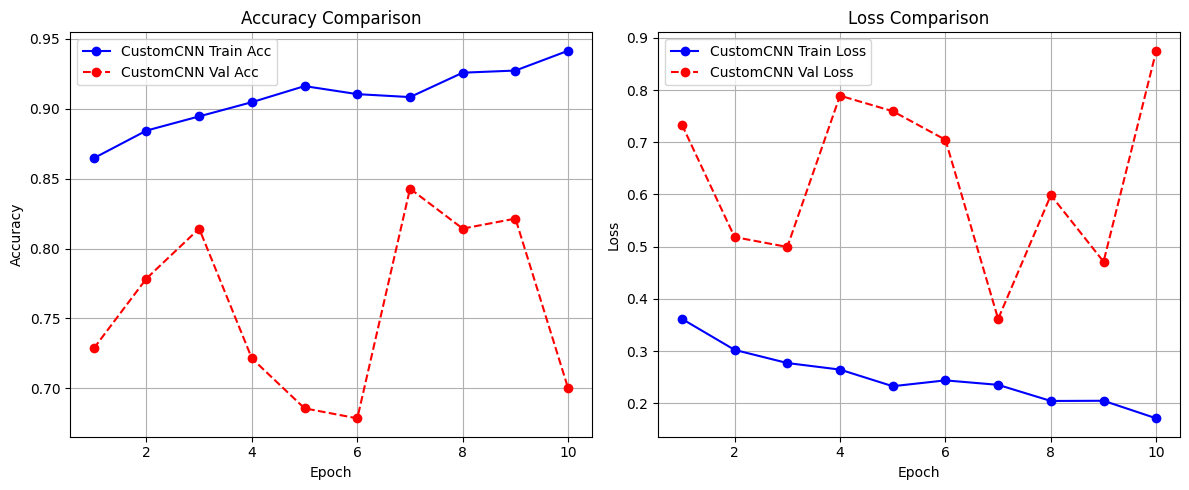

In [ ]:
fig = plot_acc_loss(num_epochs, train_losses, train_accs, val_losses, val_accs)

In [ ]:
# @title 예측 결과 시각화
import random

def visualize_predictions_balanced(model, test_loader, num_samples_per_class=5):
    model.eval()
    images, labels, preds = [], [], []          # 이미지, 정답, 예층 저장할 리스트

    with torch.no_grad():                       # 평가에서는 gradient 불필요
        for inputs, targets in test_loader:     # 배치 단위로 test 데이터 로드
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)             # forward 예측
            _, pred = torch.max(outputs, 1)     # 가장 큰 로짓값 → 예측 클래스

            images.extend(inputs.cpu())         # cpu로 옮겨 저장
            labels.extend(targets.cpu().numpy())  # 실제 라벨 저장
            preds.extend(pred.cpu().numpy())    # 예측 라벨 저장

    # tensor 리스트 정리
    images = torch.stack(images)                # 이미지 리스트 → 하나의 텐서
    label = list(labels)
    preds = list(preds)

    class_names = ["Normal", "Pneumonia"]

    # 클래스별 샘플 인덱스 랜덤 선택
    normal_indices = [i for i in range(len(labels)) if labels[i] == 0]          # 정답이 Normal인 인덱스
    pneumonia_indices = [i for i in range(len(labels)) if labels[i] == 1]       # 정답이 pneumonia인 인덱스

    selected_normals = random.sample(normal_indices, num_samples_per_class)         # Normal 중 5개 샘플
    selected_pneumonias = random.sample(pneumonia_indices, num_samples_per_class)   # pneumonia 중 5개 샘플

    selected_indices = selected_normals + selected_pneumonias                       # 최종 선택된 인덱스 10개

    # 시각화
    fig, axes = plt.subplots(2, num_samples_per_class, figsize=(15,6))

    for i, idx in enumerate(selected_indices):
        img = images[idx].squeeze().numpy().transpose(1,2,0)            # Tensor → NumPy, (C,H,W) → (H,W,C)
        img = (img * 0.5) + 0.5                                         # 정규화 해제
        row = 0 if i < num_samples_per_class else 1                     # 0행 >> normal 1행>>pneumonia
        col = i % num_samples_per_class                                 # 열 번호 계산

        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(
            f"True: {class_names[label[idx]]}\nPred: {class_names[preds[idx]]}"     # 제목: 정답과 예측 비교
        )
        axes[row, col].axis('off')                                                  # 축 제거

    plt.suptitle("Predictions: Normal (Top Row) / Pneumonia (Bottom Row)")
    plt.show()

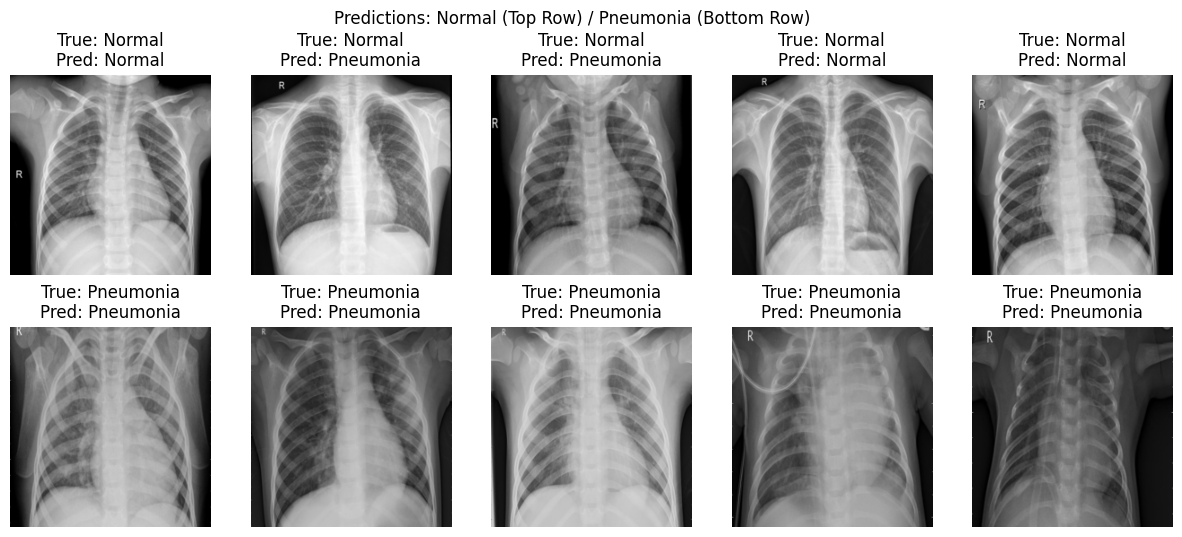

In [ ]:
# 시각화
title = "basic"
load_path = os.path.join(path, f"{model_basic.__class__.__name__}_{title}_best.pth")
model_basic.load_state_dict(torch.load(load_path))

visualize_predictions_balanced(model_basic, test_loader, num_samples_per_class=5)

# Transfer Learning

In [ ]:
# @title Feature Extraction 모델 설정

import torch
import torch.nn as nn
import torchvision.models as models                     # TorchVision에 포함된 사전 학습 모델 불러오기
# from torchvision.models import resnet18, ResNet18_Weights

num_classes = 2                                         # 이번 문제는 normal(0), Pneumonia(1) 클래스 2개

# 사전 학습된 ResNet-18 로드(ImageNet 1000 클래스에서 학습된 가중치 사용)
model_fe = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")
# model_fe = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Feature Extractor 동결(기존 학습된 특징 추출 부분은 업데이트 X)
for param in model_fe.parameters():
    param.requires_grad = False                         # 역전파 시 gradient 계산 안함

# Classifier 교체(마지막 Fully Connected Layer를 새로 정의)
num_features = model_fe.fc.in_features                   # 기존 FC 입력 차원 크기(512차원)
model_fe.fc = nn.Linear(num_features, num_classes)       # 새 출력층 512 → 2

model_fe = model_fe.to(device)

# 모델 내부 구조 확인
for ch in model_fe.named_children():
    print(ch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 97.3MB/s]


('conv1', Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))
('bn1', BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
('relu', ReLU(inplace=True))
('maxpool', MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False))
('layer1', Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kerne

In [ ]:
import os, torch
from torchvision.models import resnet18, ResNet18_Weights

# 1) 캐시 위치와 파일 존재 여부 확인
cache_dir = os.path.expanduser("~/.cache/torch/hub/checkpoints")
print("cache_dir:", cache_dir)
print("files:", os.listdir(cache_dir) if os.path.exists(cache_dir) else "캐시 폴더 없음")

# 2) 실제로 프리트레인을 불러왔는지 간단 검증(가중치 값 확인)
m = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
with torch.no_grad():
    w = m.conv1.weight
    print("conv1 weight shape:", tuple(w.shape))
    print("conv1 weight abs-mean:", w.abs().mean().item())

cache_dir: /root/.cache/torch/hub/checkpoints
files: ['resnet18-f37072fd.pth']
conv1 weight shape: (64, 3, 7, 7)
conv1 weight abs-mean: 0.0761537179350853


In [ ]:
# @title Feature Extraction Train

# 손심 함수 정의 (분류 문제에 적합)
loss_fn = nn.CrossEntropyLoss()
# 입력 : 모델의 로짓
# 정답 : 클래스 인덱스
# 출력 : 예측값과 정답의 차이를 수치로 표현한 손실갑

opt = optim.Adam(
    model_fe.fc.parameters(),           # 마지막 Fully Connected Layer(fc)파라미터만 학습
    lr=0.0001                           # 학습율 0.0001 작게설정하여 안정적 학습
)

# Feature Extraction 모델 학습
train_losses_fe, train_accs_fe, val_losses_fe, val_accs_fe = train_model(
    num_epochs,
    model_fe,               # Feature Extraction용 ResNet-18
    loss_fn,                # 손실함수
    opt,
    train_loader,
    val_loader,
    device,
    title="FE"              # 모델 저장 파일명 태그(예: "CustomCNN_FE_best.pth"
)


[Epoch 1/10]


Train Loss: 0.6680 / Acc: 0.5922
Val   Loss: 0.5779 / Acc: 0.7357

[Epoch 2/10]


Train Loss: 0.5252 / Acc: 0.7968
Val   Loss: 0.4959 / Acc: 0.7929

[Epoch 3/10]


Train Loss: 0.4445 / Acc: 0.8664
Val   Loss: 0.4206 / Acc: 0.8071

[Epoch 4/10]


Train Loss: 0.3890 / Acc: 0.8844
Val   Loss: 0.3885 / Acc: 0.8286

[Epoch 5/10]


Train Loss: 0.3481 / Acc: 0.8993
Val   Loss: 0.3642 / Acc: 0.8143

[Epoch 6/10]


Train Loss: 0.3256 / Acc: 0.9041
Val   Loss: 0.3488 / Acc: 0.8429

[Epoch 7/10]


Train Loss: 0.3077 / Acc: 0.9070
Val   Loss: 0.3341 / Acc: 0.8429

[Epoch 8/10]


Train Loss: 0.2923 / Acc: 0.9070
Val   Loss: 0.3238 / Acc: 0.8429

[Epoch 9/10]


Train Loss: 0.2767 / Acc: 0.9089
Val   Loss: 0.3137 / Acc: 0.8429

[Epoch 10/10]


Train Loss: 0.2680 / Acc: 0.9101
Val   Loss: 0.3084 / Acc: 0.8643


In [ ]:
# @title Feature Extraction Test

title = "FE"            # 학습시 사용한 태그
load_path = os.path.join(path, f"{model_fe.__class__.__name__}_{title}_best.pth")
                    # 저장된 모델 가중치 파일 경로 생성 예: "./저장폴더/ResNet_FE_bset.pth"
model_fe.load_state_dict(torch.load(load_path))
                    # 저당된 state_dict(파라미터 값들)을 현재 모델에 로드 !!모델 구조(model_fe)는 동일하게 정의 되어 있어야 함

test_loss, test_acc = evaluation_model(
    model_fe,       # 불러온 Feature Extraction 모델
    test_loader,
    loss_fn,
    device,
    Test_mode=True  # 테스트 모드 >> classification_report까지 출력
)


Final Test Accuracy: 0.8400
              precision    recall  f1-score   support

      Normal     0.8375    0.7128    0.7701       188
  Pneumonnia     0.8412    0.9167    0.8773       312

    accuracy                         0.8400       500
   macro avg     0.8393    0.8147    0.8237       500
weighted avg     0.8398    0.8400    0.8370       500



# Partial Fine-Tuning

In [ ]:
# @title Partial Fine-Tuning 모델

# 사전학습된 ResNet-18 불러오기(ImageNet 가중치 포함)
model_pft = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# Feature Extraction 동결 (일부 계층만 학습 가능하게 설정)
for name, param in model_pft.named_parameters():
    if "layer4" in name or "fc" in name:            # 조건: 마지막블록(layer4) & FC 레이어
        param.requires_grad = True                  # 학습 가능
    else:
        param.requires_grad = False                 # 동결(gradient계산안함)

# classifier 교체(출력층 변경: ImageNet 1000 >> Pneumonia 2 클래스)
num_features = model_pft.fc.in_features             # 기존 FC 입력 크기(512차원)
model_pft.fc = nn.Linear(num_features, num_classes) # 새 출력층 512 → 2

print("Trainable parameters:")
for name, param in model_pft.named_parameters():
    if param.requires_grad:
        print(name)     # 학습 가능한 레이어 이름 출력

model_pft = model_pft.to(device)

Trainable parameters:
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.weight
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.downsample.0.weight
layer4.0.downsample.1.weight
layer4.0.downsample.1.bias
layer4.1.conv1.weight
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.conv2.weight
layer4.1.bn2.weight
layer4.1.bn2.bias
fc.weight
fc.bias


In [ ]:
# @title Partial Fine-Tuning Model Train 1

# 손실 함수 정의
loss_fn = nn.CrossEntropyLoss()

opt = optim.Adam(
    model_pft.parameters(),         # 학습 가능한 파라미터(layer4 + fc레이어)
    lr=0.00001                      # 학습률 매우작게 설정 (안정성을 위함)
)

# 학습실행
train_losses_pft, train_accs_pft,val_losses_pft, val_accs_pft = train_model(
    num_epochs,
    model_pft,              # Partial Fine-Tuning ResNet-18
    loss_fn,
    opt,
    train_loader,
    val_loader,
    device,
    title='PFT'
)


[Epoch 1/10]


Train Loss: 0.5862 / Acc: 0.6980
Val   Loss: 0.5720 / Acc: 0.7286

[Epoch 2/10]


Train Loss: 0.1501 / Acc: 0.9479
Val   Loss: 0.3162 / Acc: 0.8857

[Epoch 3/10]


Train Loss: 0.1235 / Acc: 0.9532
Val   Loss: 0.2674 / Acc: 0.9143

[Epoch 4/10]


Train Loss: 0.1056 / Acc: 0.9605
Val   Loss: 0.2573 / Acc: 0.9071

[Epoch 5/10]


Train Loss: 0.0998 / Acc: 0.9615
Val   Loss: 0.2699 / Acc: 0.9143

[Epoch 6/10]


Train Loss: 0.0945 / Acc: 0.9655
Val   Loss: 0.2644 / Acc: 0.9143

[Epoch 7/10]


Train Loss: 0.0822 / Acc: 0.9686
Val   Loss: 0.2904 / Acc: 0.9000

[Epoch 8/10]


Train Loss: 0.0766 / Acc: 0.9720
Val   Loss: 0.2816 / Acc: 0.9071

[Epoch 9/10]


Train Loss: 0.0807 / Acc: 0.9697
Val   Loss: 0.2439 / Acc: 0.9143

[Epoch 10/10]


Train Loss: 0.0708 / Acc: 0.9734
Val   Loss: 0.2657 / Acc: 0.9000


In [ ]:
# @title Partial Fine_Tuning Model Train 2

# 학습이 필요한 파라미터들만 업데이트되도록 설정
params_to_update = [p for p in model_pft.parameters() if p.requires_grad]      # requires_grad=True로 설정된 파라미터만 리스트에 담음
print([i for i in params_to_update])

# 손실함수 정의
loss_fn = nn.CrossEntropyLoss()

opt = optim.Adam(params_to_update, lr=0.00001)                                 # params_to_update만 업데이트 하므로 동결된레이어는 변경되지 않음

# 학습 실행
train_losses_pft, train_accs_pft, val_losses_pft, val_accs_pft = train_model(
    num_epochs,
    model_pft,
    loss_fn,
    opt,
    train_loader,
    val_loader,
    device,
    title="PET"
)

[Parameter containing:
tensor([[[[-1.0665e-02, -1.8284e-02, -2.1467e-02],
          [ 2.1377e-02,  2.4870e-02,  2.9908e-02],
          [ 4.5055e-02,  3.4521e-02,  5.0743e-02]],

         [[-8.3184e-03,  2.4631e-03, -5.3785e-03],
          [ 5.8059e-03,  1.3767e-02, -4.6221e-03],
          [-4.0394e-03,  1.3240e-02,  8.6673e-04]],

         [[ 1.8282e-02, -1.0608e-02, -1.3880e-02],
          [ 8.3824e-03, -2.3575e-03, -1.1544e-02],
          [-5.0078e-03, -2.9036e-02, -9.0484e-03]],

         ...,

         [[-1.3320e-02,  1.6973e-02,  9.4296e-04],
          [ 7.2432e-03,  6.9319e-03,  1.1099e-02],
          [ 2.3025e-02,  1.0358e-02,  4.1460e-03]],

         [[ 1.9092e-02,  1.3628e-02,  1.9268e-02],
          [-4.7810e-03,  9.2255e-03,  2.4185e-02],
          [-5.1345e-03,  2.3551e-02,  3.4652e-02]],

         [[ 2.5175e-02,  2.2866e-02,  4.2669e-02],
          [ 1.3157e-02,  2.1133e-03,  1.3080e-02],
          [-6.9031e-03, -1.5091e-03, -9.9274e-03]]],


        [[[ 5.6078e-04, -4.675

Train Loss: 0.0412 / Acc: 0.9864
Val   Loss: 0.2280 / Acc: 0.9143

[Epoch 2/10]


Train Loss: 0.0475 / Acc: 0.9833
Val   Loss: 0.2270 / Acc: 0.9143

[Epoch 3/10]


Train Loss: 0.0430 / Acc: 0.9849
Val   Loss: 0.2341 / Acc: 0.9143

[Epoch 4/10]


Train Loss: 0.0388 / Acc: 0.9856
Val   Loss: 0.2656 / Acc: 0.9214

[Epoch 5/10]


Train Loss: 0.0400 / Acc: 0.9854
Val   Loss: 0.2280 / Acc: 0.9286

[Epoch 6/10]


Train Loss: 0.0412 / Acc: 0.9850
Val   Loss: 0.2163 / Acc: 0.9357

[Epoch 7/10]


Train Loss: 0.0343 / Acc: 0.9885
Val   Loss: 0.2264 / Acc: 0.9143

[Epoch 8/10]


Train Loss: 0.0371 / Acc: 0.9868
Val   Loss: 0.2053 / Acc: 0.9286

[Epoch 9/10]


Train Loss: 0.0309 / Acc: 0.9910
Val   Loss: 0.2420 / Acc: 0.9357

[Epoch 10/10]


Train Loss: 0.0300 / Acc: 0.9887
Val   Loss: 0.2198 / Acc: 0.9286


In [ ]:
 @title Partial Fine_Tuning Model Test

title = "PET"
load_path = os.path.join(path, f"{model_pft.__class__.__name__}_{title}_best.pth")
model_pft.load_state_dict(torch.load(load_path))

test_loss, test_acc = evaluation_model(model_pft, test_loader, loss_fn, device, Test_mode=True)

# Full Fine Tuning

In [ ]:
# @title Full Fine-Tuning 모델 설정

# 사전 학습된 ResNet 모델 로드
model_fft = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1")

# 모든 층 학습 가능하도록 설정
for param in model_fft.parameters():
    param.requires_grad = True

# classifier 교체
num_features = model_fft.fc.in_features                 # 기존 fully connected layer 입력 크기
model_fft.fc = nn.Linear(num_features, num_classes)     # 새 출력층 생성
model_fft = model_fft.to(device)

In [ ]:
# @title Fully Fine-Tuning model 학습

# 손실 함수와 optim 설정
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model_fft.parameters(), lr=0.0001)

# 학습 실행
train_losses_fft, train_accs_fft, val_losses_fft, val_accs_fft = train_model(num_epochs,
                                                                             model_fft,
                                                                             loss_fn,
                                                                             opt,
                                                                             train_loader,
                                                                             val_loader,
                                                                             device,
                                                                             title = 'FFT')


[Epoch 1/10]


Train Loss: 0.1237 / Acc: 0.9521
Val   Loss: 0.2575 / Acc: 0.9000

[Epoch 2/10]


Train Loss: 0.0643 / Acc: 0.9783
Val   Loss: 0.2164 / Acc: 0.9143

[Epoch 3/10]


Train Loss: 0.0504 / Acc: 0.9818
Val   Loss: 0.2310 / Acc: 0.9429

[Epoch 4/10]


Train Loss: 0.0411 / Acc: 0.9843
Val   Loss: 0.5902 / Acc: 0.8357

[Epoch 5/10]


Train Loss: 0.0345 / Acc: 0.9866
Val   Loss: 0.2016 / Acc: 0.9357

[Epoch 6/10]


Train Loss: 0.0355 / Acc: 0.9864
Val   Loss: 0.2086 / Acc: 0.9429

[Epoch 7/10]


Train Loss: 0.0306 / Acc: 0.9904
Val   Loss: 0.2243 / Acc: 0.9357

[Epoch 8/10]


Train Loss: 0.0240 / Acc: 0.9904
Val   Loss: 0.3353 / Acc: 0.8929

[Epoch 9/10]


Train Loss: 0.0156 / Acc: 0.9944
Val   Loss: 0.1953 / Acc: 0.9429

[Epoch 10/10]


Train Loss: 0.0353 / Acc: 0.9841
Val   Loss: 0.1810 / Acc: 0.9429


In [ ]:
# @title Fully Fine-tuning model Test

title = 'FFT'
load_path = os.path.join(path, f"{model_fft.__class__.__name__}_{title}_best.pth")
model_fft.load_state_dict(torch.load(load_path))

test_loss, test_acc = evaluation_model(model_fft, test_loader, loss_fn, device, Test_mode=True)


Final Test Accuracy: 0.9260
              precision    recall  f1-score   support

      Normal     0.8683    0.9468    0.9059       188
  Pneumonnia     0.9661    0.9135    0.9390       312

    accuracy                         0.9260       500
   macro avg     0.9172    0.9301    0.9224       500
weighted avg     0.9293    0.9260    0.9266       500



# Pickle을 이용한 데이터 저장 및 불러오기

In [ ]:
# 파이썬 객체를 파일로 저장/불러오기 위한 라이브러리
import pickle

# 모든 모델의 학습 기록을 저장할 딕셔너리 생성
training_histories = {
    'basic': {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
    },
    'FE': {
        'train_losses': train_losses_fe,
        'train_accs': train_accs_fe,
        'val_losses': val_losses_fe,
        'val_accs': val_accs_fe,
    },
    'PFT': {
        'train_losses': train_losses_pft,
        'train_accs': train_accs_pft,
        'val_losses': val_losses_pft,
        'val_accs': val_accs
    },
    'FFT': {
        'train_losses': train_losses_fft,
        'train_accs': train_accs_fft,
        'val_losses': val_losses_fft,
        'val_accs': val_accs_fft
    }
}

# pickle 파일 저장 경로 지정
pickle_filename = os.path.join(path, "training_histories.pkl")

# 파일 쓰기 모드
with open(pickle_filename, 'wb') as f:                  # 'wb' → binary write로 열고
    pickle.dump(training_histories, f)                  # training_histories 객체 → 파일 직렬화(dump)

print(f"Training history saved to {pickle_filename}")

Training history saved to /content/drive/MyDrive/study/data/training_histories.pkl


In [ ]:
# 피클 파일 불러오기

with open(pickle_filename, 'rb') as f:
    loaded_training_histories = pickle.load(f)

print("\nTraining history loaded successfully:")

# 예시: 불러온 데이터에서 basic 모델의 train loss 확인
print("\nExample: Basic model train losses from loaded data:")
print(loaded_training_histories['basic']['train_losses'])


Training history loaded successfully:

Example: Basic model train losses from loaded data:
[0.36184233829287665, 0.3024513342994854, 0.2772360913958286, 0.2646757584590853, 0.23286573172895456, 0.24402037537171065, 0.23546553489986372, 0.20459631295657596, 0.20496210090221803, 0.17132253574630235]


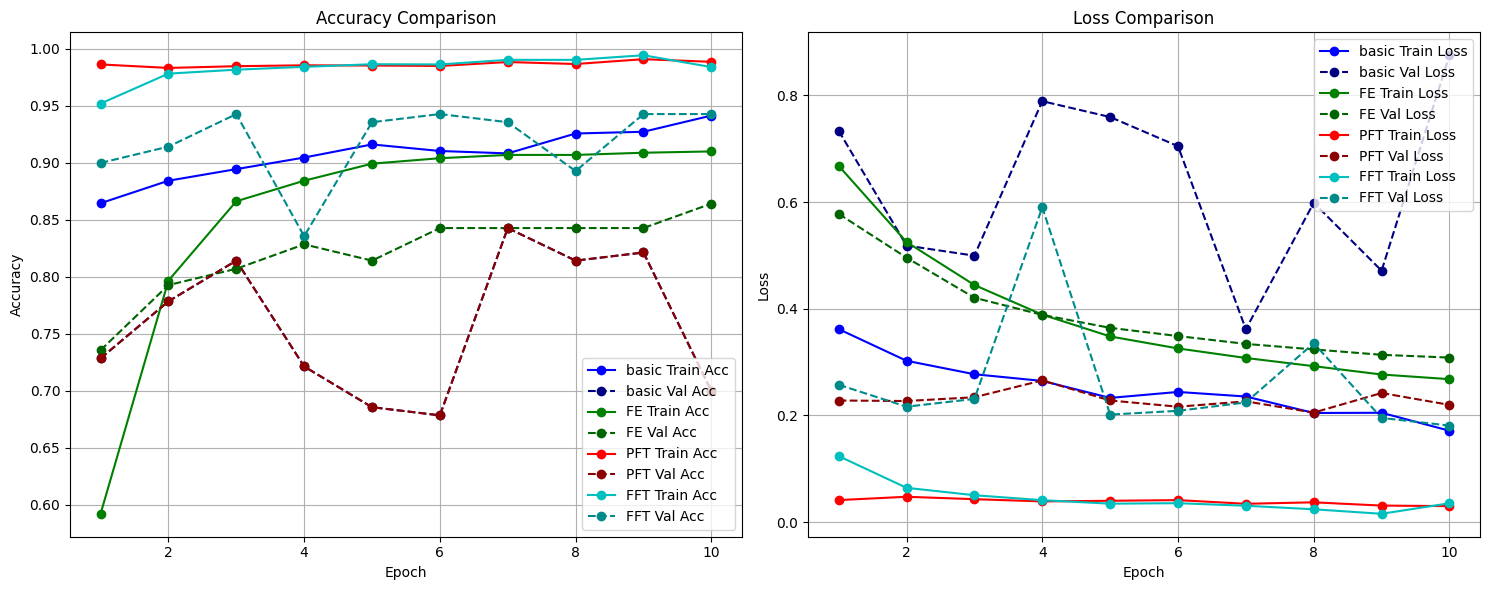

In [ ]:
import matplotlib.pyplot as plt

def plot_all_acc_loss(loaded_training_histories, num_epochs):
    epochs = range(1, num_epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))             # 1행 2열 subplot 생성
    # axes[0] → Accuracy 그래프, axes[1] → Loss 그래프

    # Accuracy 그래프 세팅
    ax1 = axes[0]
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Comparison')
    ax1.grid(True)

    # Loss 그래프 세팅
    ax2 = axes[1]
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title('Loss Comparison')
    ax2.grid(True)

    # 모델별 색상 설정
    colors = {
        'basic': ('b', 'navy'),         # 기본 CNN
        'FE': ('g', 'darkgreen'),       # Feature Extraction
        'PFT': ('r', 'darkred'),        # Partial Fine-Tuning
        'FFT': ('c', 'darkcyan')        # Fully Fine_Tuning
    }
    styles = {'train': 'o-', 'val': 'o--'}      # train=실선 val=점선

    # 각 모델 학습 기록 그리기
    for model_name, history in loaded_training_histories.items():
        # 모델별 색상 분리
        color_train, color_val = colors[model_name]

        # Accuracy
        ax1.plot(epochs, history['train_accs'], styles['train'], c=color_train, label=f'{model_name} Train Acc')
        ax1.plot(epochs, history['val_accs'], styles['val'], c=color_val, label=f'{model_name} Val Acc')

        # Loss
        ax2.plot(epochs, history['train_losses'], styles['train'], c=color_train, label=f'{model_name} Train Loss')
        ax2.plot(epochs, history['val_losses'], styles['val'], c=color_val, label=f'{model_name} Val Loss')

    ax1.legend()
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return fig

# 저장된 training history를 사용하여 그래프 그리기
fig = plot_all_acc_loss(loaded_training_histories, num_epochs)